In [230]:
## ECE 397 - Individual Study in ECE Problems
## Professor: Thomas Moon
## Student: Jihyun Seo

## This program uses an SDR device to transmit and receive a message wirelessly.
## The message ("Hello world") is converted to a bitstream using ASCII encoding, then
## processed through essential wireless communication stages.

## Communication System Overview:
## - Modulation: The bitstream is modulated using 4-QAM for simplicity.
## - Processing: The system applies pulse shaping, matched filtering, symbol timing recovery, 
##               frame synchronization, channel equalization, and demodulation.

## Objective:
## The goal is to successfully transmit "Hello world" and accurately recover it at the receiver 
## by performing these core wireless communication functions.


In [287]:
import numpy as np
import matplotlib.pyplot as plt 
import adi
from scipy import signal


In [232]:
############################## Generate BPSK frame ##########################################################################################  

#############  Parameters for generating BPSK symbols ############ 
sps = 8  # Samples per symbol (upsampling factor)
fs = 1e6  # Sampling rate of 1 MHz
carrier_freq = 2e9  # Carrier frequency of 2 GHz


#############  Step 1: Barker-13 Preamble (1s and -1s)
barker_13 = np.array([1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1])

#############  Step 2: Generate a guard band (same length as the preamble, filled with zeros)
guard_band = np.zeros(len(barker_13))




In [233]:
#################### Step 1: Define the message and convert it to ASCII bits ##################


message = "Hello World"
ascii_values = [ord(char) for char in message]  # Convert each character to ASCII
bits = np.array([int(bit) for char in ascii_values for bit in format(char, '08b')])  # Convert to 8-bit binary

print(ascii_values)
print(bits)


[72, 101, 108, 108, 111, 32, 87, 111, 114, 108, 100]
[0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1
 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1
 1 0 1 1 0 0 0 1 1 0 0 1 0 0]


In [234]:
# Step 2: Define modulation parameters
M = 4  # 4-QAM
bits_per_symbol = int(np.log2(M))
num_data_symbols = len(bits) // bits_per_symbol  # Number of symbols that can be formed from bits
bits = bits[:num_data_symbols * bits_per_symbol]  # Truncate to fit into complete symbols if needed


In [235]:
############# M-QAM Decision ##################### 

M = 4  ## M-QAM [ if 2 , it is BPSK ]
bits_per_symbol = int(np.log2(M))


# Define modulation mappings
if M == 2:  # BPSK
    # BPSK with Gray coding: 0 -> +1, 1 -> -1
    gray_mapping = {
        (0,): -1,
        (1,): 1
    }
    normalization_factor = 1

elif M == 4:  # 4-QAM
    # 4-QAM with Gray coding
    gray_mapping = {
        (0, 0): -1 - 1j,
        (0, 1): 1 - 1j,
        (1, 1):  1 + 1j,
        (1, 0):  -1 + 1j
    }
    normalization_factor = np.sqrt(2)

elif M == 16:  # 16-QAM
    # 16-QAM with Gray coding
    gray_mapping = {
        (1, 0, 0, 0): -3 + 3j, (1, 0, 0, 1): -1 + 3j,
        (1, 0, 1, 1): 1 + 3j, (1, 0, 1, 0): 3 + 3j,
        
        (1, 1, 0, 0): -3 + 1j, (1, 1, 0, 1): -1 + 1j,
        (1, 1, 1, 1): 1 + 1j, (1, 1, 1, 0): 3 + 1j,
        
        (0, 1, 0, 0):  -3 - 1j, (0, 1, 0, 1):  -1 - 1j,
        (0, 1, 1, 1):  1 -1j, (0, 1, 1, 0):  3 - 1j,
        
        (0, 0, 0, 0):  -3 - 3j, (0, 0, 0, 1):  -1 - 3j,
        (0, 0, 1, 1):  1 - 3j, (0, 0, 1, 0):  3 - 3j
    }
    normalization_factor = np.sqrt(10)   






In [236]:

################# Map bits to symbols #################

mqam_symbols = []
symbol_labels = []  # To store labels in correct order

for i in range(0, len(bits), bits_per_symbol):
    # Adjust the order of bits if necessary to align with MSB-LSB orientation
    bit_tuple = tuple(bits[i:i + bits_per_symbol])  # Keep the original order without reversing
    symbol = gray_mapping[bit_tuple]
    
    mqam_symbols.append(symbol / normalization_factor)  # Normalize the symbol
    symbol_labels.append("".join(map(str, bit_tuple)))  # Save the bit label in correct order

# Convert to NumPy array
mqam_symbols = np.array(mqam_symbols)


# Print mqam_symbols and corresponding labels
#print("Symbols:", mqam_symbols)

#print("\nLabels:", symbol_labels)

#print("\noriginal bits: ",bits)


############ YOUR CODE STOPS HERE ############



In [237]:
#############  Step 5: Create a full frame: Preamble + Guard Band + Data Symbols
frame = np.concatenate((barker_13,barker_13, guard_band, mqam_symbols))
#print(frame)  #check if frame is good




In [238]:
#############  Step 6: Upsample the full frame by sps (insert sps-1 zeros between each symbol)
up_sym = np.zeros(len(frame) * sps, dtype = complex)  # Create an array of zeros
up_sym[::sps] = frame  # Insert symbols into every sps-th position
#print(len(up_sym)) = 336  = 42 * 8 = symbols * samples (upsampling factor)



In [239]:
######################### Set up PlutoSDR Tx and Rx ######################## 
# Transmit settings
sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(fs)

# Config Tx
# filter cutoff, just set it to the same as sample rate, valid range is 200 kHz to 20 MHz
sdr.tx_rf_bandwidth = int(fs) 
# set carrier frequency, valid range is 380 MHz to 3.8GHz
sdr.tx_lo = int(carrier_freq)
# set tx power, valid range is -90 to 0 dB
sdr.tx_hardwaregain_chan0 = -50

# Config Rx
sdr.rx_lo = int(carrier_freq)
sdr.rx_rf_bandwidth = int(fs)
sdr.rx_buffer_size = 128
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 30.0




In [240]:
############# Define RRC Filter ###################

def rrcosfilter(N, alpha, Ts, Fs):
    """
    Generates a root raised cosine (RRC) filter (FIR) impulse response.

    Parameters
    ----------
    N : int
        Length of the filter in samples.

    alpha : float
        Roll off factor (Valid values are [0, 1]).

    Ts : float
        Symbol period in seconds.

    Fs : float
        Sampling Rate in Hz.

    Returns
    ---------

    time_idx : 1-D ndarray of floats
        Array containing the time indices, in seconds, for
        the impulse response.

    h_rrc : 1-D ndarray of floats
        Impulse response of the root raised cosine filter.
    """

    T_delta = 1/float(Fs)
    time_idx = ((np.arange(N)-N/2))*T_delta
    sample_num = np.arange(N)
    h_rrc = np.zeros(N, dtype=float)

    for x in sample_num:
        t = (x-N/2)*T_delta
        if t == 0.0:
            h_rrc[x] = 1.0 - alpha + (4*alpha/np.pi)
        elif alpha != 0 and t == Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        elif alpha != 0 and t == -Ts/(4*alpha):
            h_rrc[x] = (alpha/np.sqrt(2))*(((1+2/np.pi)* \
                    (np.sin(np.pi/(4*alpha)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*alpha)))))
        else:
            h_rrc[x] = (np.sin(np.pi*t*(1-alpha)/Ts) +  \
                    4*alpha*(t/Ts)*np.cos(np.pi*t*(1+alpha)/Ts))/ \
                    (np.pi*t*(1-(4*alpha*t/Ts)*(4*alpha*t/Ts))/Ts)

    return time_idx, h_rrc



##################### Corrected part as of Oct 2nd ####################################
#len(frame) = 42 = len(barker) + len(guard) + len(symbols) = 13 + 13 + 16

N = len(frame) * sps   # Filter length in terms of samples per symbol = length of upsampled symbol for frame
alpha = 1  # Roll-off factor 
f_sym = fs/sps   # Symbol rate =  [fs] /[sps]  sampling rate / number of samples
                 # sampling rate = symbol_rate * number of samples ( symbol factor)

# Calculate Ts (symbol period) and Fs (sampling rate)
Ts = 1 / f_sym         # Symbol period in seconds (1 microsecond for 1 MHz)
Fs = sps * f_sym       # Sampling rate in Hz  = number of samples * symbol rate

time_idx, rrc_filter = rrcosfilter(N, alpha, Ts, Fs)

##################### Corrected part as of Oct 2nd ends ####################################

In [241]:
# Pulse shaping by convolving upsampled symbols with RRC filter
your_Tx_samples = np.convolve(up_sym, rrc_filter, mode='same')


In [242]:
############## Scale and transmit pulse-shaped samples #####################
tx_samples = your_Tx_samples * 2**14  # Scale for SDR transmission
sdr.tx_cyclic_buffer = True  # Enable continuous transmission
sdr.tx(tx_samples)



In [243]:
###################### Receive samples #########################
sdr.rx_buffer_size = 2 * tx_samples.size  # Set buffer size for reception

# Clear the buffer to avoid stale data
for i in range(5):
    sdr.rx()  # Clear stale buffer data

# Receive the transmitted signal
rx_samples_raw = sdr.rx()
rx_samples = rx_samples_raw * 2**-14  # Scale received samples back down

# Stop transmitting
sdr.tx_destroy_buffer()


In [244]:

#########################   Apply matched filtering using the same RRC filter ########################  
rx_matched = np.convolve(rx_samples, rrc_filter, mode='same')


In [245]:
######################### Time recovery for rx_matched ######################## 


# Maximum energy approach for symbol timing recovery
energy = np.zeros(sps)

# Compute the energy across different offsets
for k in range(sps):
    # Take every sps-th sample starting from the k-th sample and compute energy
    energy[k] = np.sum(np.abs(rx_samples[k::sps])**2)  # Sum of squared magnitudes

# Find the offset that maximizes the energy
max_ind = np.argmax(energy)

# Align the samples using the offset with the maximum energy
rx_align = rx_samples[max_ind:] 


# covnert align to symbol
##################################################################################################  

############ Downsampling (Must be done after Time recovery but before frame synch) to covnert samples to symbols ####################

rx_align_symbol = rx_align[::sps]

# Not doing downsampling
#rx_align_symbol = rx_align

In [246]:
####################### Lab 8 : Self-reference frame synch ################################################

rx_cfo = rx_align_symbol

####################### Self-reference frame synch ########################

num_symbols = len(mqam_symbols)


from scipy.signal import find_peaks

# Define Barker sequence length
N = len(barker_13)  # Barker-13 sequence length

######### Self-reference frame sync ##############
corr = np.zeros(rx_cfo.size - 2 * N + 1)
for n in range(len(corr)):
    # Compute the correlation for each possible start position
    corr[n] = np.abs(np.sum(np.conj(rx_cfo[n:n+N]) * rx_cfo[n+N:n+2*N]))

# Use find_peaks to detect the peak
# Limit the range to look for peaks within the first 60 indices
limited_corr = corr[:60]  # Slice to limit to the first 60 indices
peaks, _ = find_peaks(limited_corr)

# Identify the first occurrence of the highest peak
max_peak_value = np.max(limited_corr[peaks])  # Maximum peak value in correlation
first_highest_peak = peaks[np.where(limited_corr[peaks] == max_peak_value)[0][0]]  # First occurrence of max peak

# Now set peak_index to this first highest peak
peak_index = first_highest_peak

# Find out the frame, then split it into preamble and data (no need to adjust `peak_index`) why?
rx_frame = rx_cfo[peak_index:peak_index + 2 * N + len(guard_band) + num_symbols]
rx_preamble = rx_frame[ : 2 * N]  # First two Barker sequences
rx_data = rx_frame[2 * N + len(guard_band):]  # Data symbols after preamble and guard band



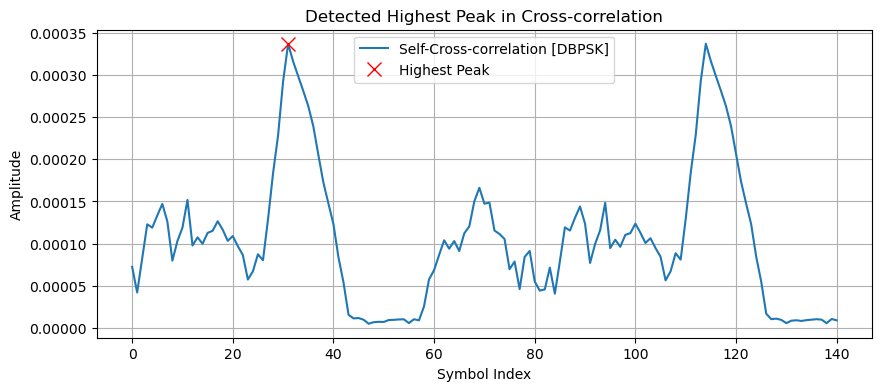

Peak index of highest peak: 31
Value of highest peak: 0.00033682263013066344


In [247]:
####################### Lab 8 : Self-reference frame synch ################################################
# Plot cross-correlation
plt.figure(figsize=(10, 4))
plt.plot(corr, label='Self-Cross-correlation [DBPSK]')  # Plot the entire correlation
plt.plot(peak_index, corr[peak_index], 'rx', label='Highest Peak', markersize=10)  # Mark only the highest peak
plt.title('Detected Highest Peak in Cross-correlation')
plt.xlabel('Symbol Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

print("Peak index of highest peak:", peak_index)
print("Value of highest peak:", corr[peak_index])

In [248]:
########################################## LAB 8 - Estimate CFO ###################################################
######################### Estimate CFO ##################################

# Step 1: Compute A
N = len(barker_13)
A = np.sum(np.conj(rx_preamble[:N]) * rx_preamble[N:2*N]) 

# Step 2: Estimate CFO
# symbol rate = 1/sampling rate <- as it is symbol originally
T_s = 1/fs

angle_A = np.angle(A)  # Extract the phase angle of A
delta_fc = -angle_A / (2 * np.pi * N * T_s)  # CFO in Hz

# Print results
print(f"Estimated CFO (Hz): {delta_fc}")

print("Angle_A : ",angle_A)

Estimated CFO (Hz): -21.258641521715553
Angle_A :  0.0017364357927779337


In [249]:
########################################## LAB 8 - Estimate CFO ##################################################
# Step 3: Compute the maximum detectable CFO range
max_cfo_range = 1 / (2 * N * T_s)
cfo_range = (-max_cfo_range, max_cfo_range)

print(f"Maximum Detectable CFO Range: {cfo_range}")

Maximum Detectable CFO Range: (-38461.53846153846, 38461.53846153846)


In [250]:
########################################## LAB 8 - Estimate CFO ##################################################
# CFO Correction
rx_preamble_cor_afterCFO = np.zeros(len(rx_preamble), dtype=complex)
rx_data_cor_afterCFO = np.zeros(len(rx_data), dtype=complex)
rx_frame_cor_afterCFO = np.zeros(len(rx_frame), dtype=complex)



# Assuming delta_fc (estimated CFO in Hz) and T_s (symbol period) are defined
for k in range(len(rx_frame)):
    rx_frame_cor_afterCFO[k] = rx_frame[k] * np.exp(1j * 2 * np.pi * delta_fc * k * T_s)  # Apply CFO correction

rx_preamble_cor_afterCFO = rx_frame_cor_afterCFO[:len(rx_preamble)]
rx_data_cor_afterCFO = rx_frame_cor_afterCFO[-len(rx_data):] # from right, starting at len(rx_data) shift left



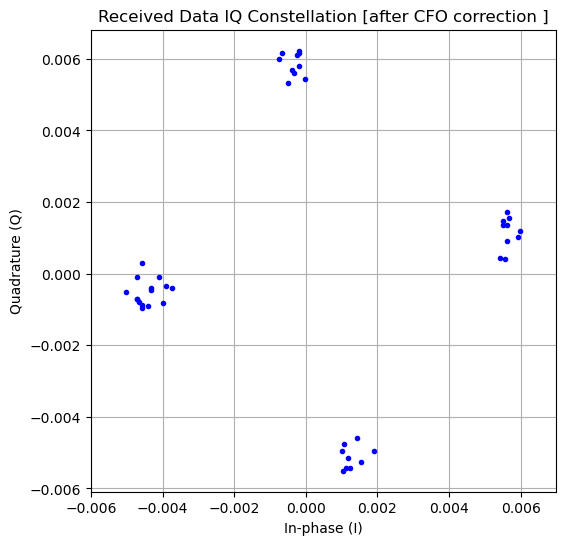

In [251]:
#Assignment 2-1: Plot the IQ constellation After CFO correction

plt.figure(figsize=(6, 6))
plt.plot(rx_data_cor_afterCFO.real, rx_data_cor_afterCFO.imag, '.', color='blue')  # Plot I vs Q components
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.title('Received Data IQ Constellation [after CFO correction ]')
plt.grid(True)

# Set equal aspect ratio for better visualization
ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
plt.show()
############ YOUR CODE STOPS HERE ############


############## CFO DONE #######################

In [252]:
############ Channel Estimation: Lab 7 ############
# Channel Estimation: 

def estimate_h(rx_preamble, tx_preamble, L):
    """
    Estimate the channel response h.

    Parameters
    ----------
    rx_preamble : 1-D ndarray of complex floats
        The received preamble.

    tx_preamble : 1-D ndarray of floats
        The original preamble sent from Tx.

    L : int
        The length of the channel.

    Returns
    -------
    hhat : 1-D ndarray of complex floats
        The estimated channel (in time-domain).
    """
    N = tx_preamble.size
    A = np.zeros((N - L + 1, L), dtype=complex)
    
    # Build the matrix A using delayed versions of the Tx preamble
    for k in range(N - L + 1):
        A[k, :] = np.flip(tx_preamble[k:k+L])
    
    # Received preamble symbols for estimation
    y = rx_preamble[L-1:N]
    
    # Least Squares solution to estimate the channel
    hhat = np.linalg.lstsq(A, y, rcond=None)[0]
    
    return hhat
############ YOUR CODE ENDS HERE ############

In [253]:
# Step 8: Estimate the channel using the preamble  
L = 1
tx_preamble = np.concatenate((barker_13, barker_13,))
hhat = estimate_h(rx_preamble_cor_afterCFO, tx_preamble, L)

In [254]:
################################# Channel Equalization : Lab 7 ###########################################
# Step 9: Correct channel by simple division
rx_data_corrected_afterChannelEQ = rx_data_cor_afterCFO / hhat  # Apply the inverse of the estimated channel


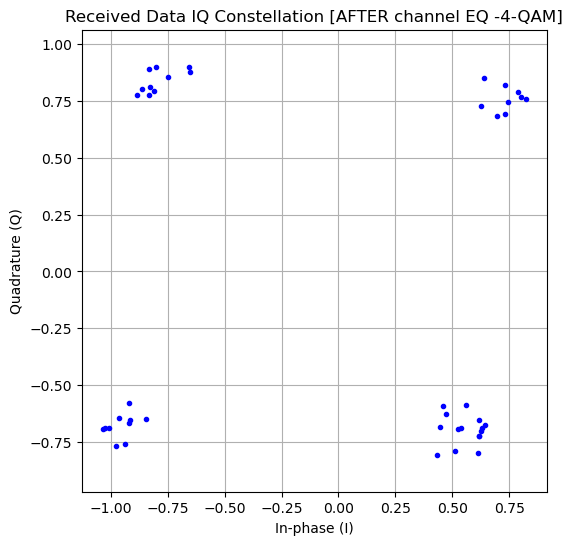

In [255]:
#Assignment 2-1: Plot the IQ constellation After CFO correction

plt.figure(figsize=(6, 6))
plt.plot(rx_data_corrected_afterChannelEQ.real, rx_data_corrected_afterChannelEQ.imag, '.', color='blue')  # Plot I vs Q components
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.title('Received Data IQ Constellation [AFTER channel EQ -4-QAM]')
plt.grid(True)

# Set equal aspect ratio for better visualization
ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')
plt.show()
############ YOUR CODE STOPS HERE ############


#print("Value of data_corrected_afterChannel EQ" , rx_data_corrected_afterChannelEQ )
#print("original mqam_symbols:", mqam_symbols)

In [256]:
####################### Demodulation ##########################
###################### YOUR CODE STARTS HERE #################
# Implement Demodulation to retrieve bits from symbols
# Input: mqam_symbols (received symbols after transmission, possibly with noise)
# Output: demod_bits (demodulated bit sequence that should match the transmitted bits)

# Initialize an empty list to store the demodulated bits
demod_bits = []

# Iterate over each received symbol in the `mqam_symbols` array
for symbol in rx_data_corrected_afterChannelEQ :
    # Initialize minimum distance to infinity for each symbol
    # This ensures that any calculated distance will be smaller initially
    min_distance = float('inf')
    
    # Initialize closest_bits to None; this will hold the bits of the closest constellation point
    closest_bits = None
    
    # Iterate over each possible constellation point in the gray_mapping
    # gray_mapping contains bit patterns as keys and complex symbols as values
    for bits_tuple, mapped_symbol in gray_mapping.items():
        
        # Calculate the Euclidean distance between the received symbol and the current constellation point
        # Normalization factor is applied to match the scale used in modulation
        distance = abs(symbol - mapped_symbol / normalization_factor)
        
        # Check if the calculated distance is the smallest one found so far
        if distance < min_distance:
            
            # Update min_distance to the new smaller distance
            min_distance = distance
            
            # Store the corresponding bit pattern of the closest constellation point
            closest_bits = bits_tuple

    
    # After finding the closest constellation point for this symbol,
    # append its corresponding bit pattern to demod_bits
    # closest_bits is a tuple, so extend() adds each bit individually to demod_bits
    demod_bits.extend(closest_bits)


# Convert the list of demodulated bits to a NumPy array for easier processing and comparison
# This is useful for calculating metrics like BER (Bit Error Rate) or for other analysis
demod_bits = np.array(demod_bits)


# At this point, `demod_bits` contains the reconstructed bitstream, with each received symbol
# mapped to the closest constellation point based on minimum Euclidean distance.



################## YOUR CODE STOPS HERE ############

# BER Calculation
print('Transmitted bits:', bits)
print('Demodulated bits:', demod_bits)
bit_err_rate = np.sum(np.abs(bits - demod_bits)) / bits.size
print('BER:', bit_err_rate)


print(mqam_symbols)

print("Value of data_corrected_afterChannel EQ" , rx_data_corrected_afterChannelEQ )


Transmitted bits: [0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1
 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1
 1 0 1 1 0 0 0 1 1 0 0 1 0 0]
Demodulated bits: [0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1
 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1
 1 0 1 1 0 0 0 1 1 0 0 1 0 0]
BER: 0.0
[ 0.70710678-0.70710678j -0.70710678-0.70710678j -0.70710678+0.70710678j
 -0.70710678-0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
  0.70710678-0.70710678j  0.70710678-0.70710678j  0.70710678-0.70710678j
 -0.70710678+0.70710678j  0.70710678+0.70710678j -0.70710678-0.70710678j
  0.70710678-0.70710678j -0.70710678+0.70710678j  0.70710678+0.70710678j
 -0.70710678-0.70710678j  0.70710678-0.70710678j -0.70710678+0.70710678j
  0.70710678+0.70710678j  0.70710678+0.70710678j -0.70710678-0.70710678j
 -0.70710678+0.70710678j -0.70710678-0.70710678j -0.70710678-0.70710678j
  0.7071067

In [257]:
# Ensure the length of demod_bits is a multiple of 8 for ASCII decoding
num_bits = len(demod_bits)
num_complete_bytes = num_bits // 8
demod_bits = demod_bits[:num_complete_bytes * 8]  # Truncate any extra bits if necessary

# Step 1: Group bits into 8-bit segments
ascii_characters = []
for i in range(0, len(demod_bits), 8):
    byte_bits = demod_bits[i:i + 8]  # Take 8 bits at a time
    # Convert 8 bits to a decimal integer
    ascii_value = int(''.join(str(bit) for bit in byte_bits), 2)
    # Convert to ASCII character
    ascii_characters.append(chr(ascii_value))

# Join all characters to form the final decoded message
decoded_message = ''.join(ascii_characters)

# Print the decoded message
print("Decoded message from demodulated bits:", decoded_message)


Decoded message from demodulated bits: Hello World
